### Preamble / Imports

Define TeX macros for notebook notation
$$
\newcommand\pmatrix[1]{\begin{pmatrix}#1\end{pmatrix}} 
\newcommand\bmatrix[1]{\begin{bmatrix}#1\end{bmatrix}} 
\newcommand\dmatrix[1]{\begin{dmatrix}#1\end{dmatrix}} 
\renewcommand\vec{\mathbf}
$$

In [227]:
## Preamble / required packages
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline


# Why numerical linear algebra?

+ Optimization / machine learning; solving large systems of equations; dynamical systems theory

## Two major areas

+ Inverting large matrices
+ + Linear solving, Conditioning
+ + LU Factorization

+ Spectral Decomposition
+ + Data analysis, dynamical systems
+ + QR algorithm

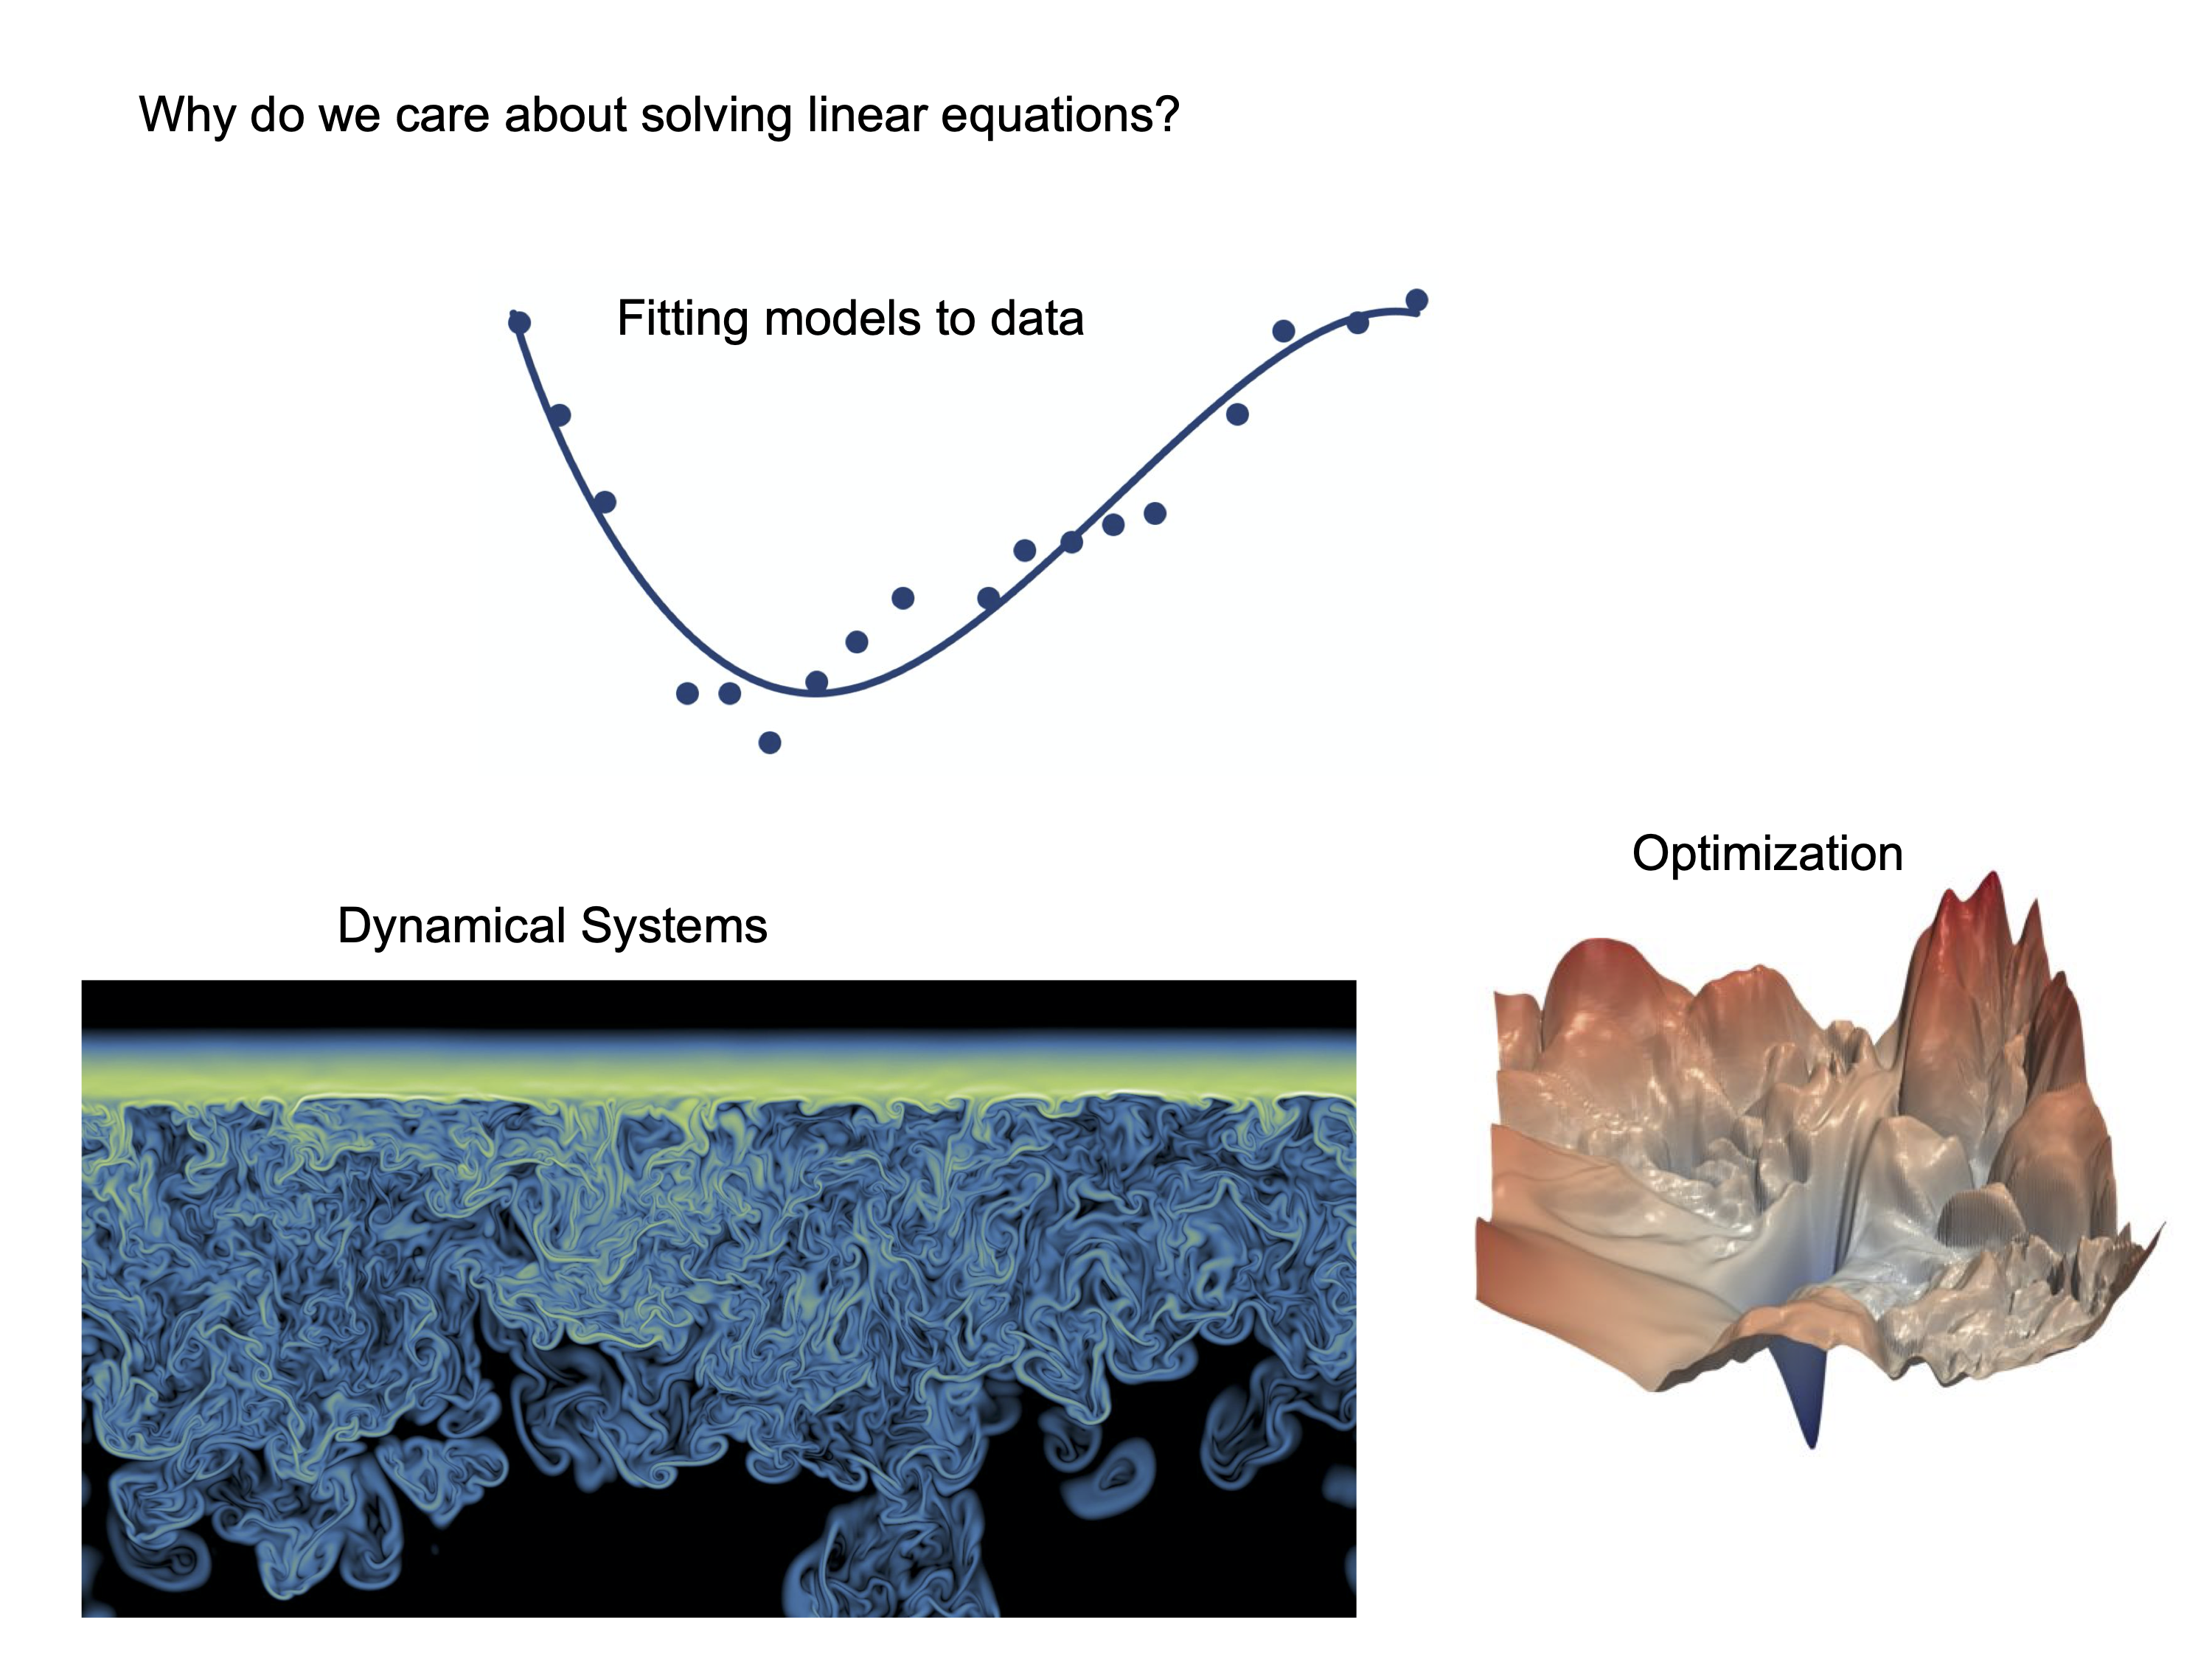

In [2]:
Image("../resources/algebra1.png", width=800)

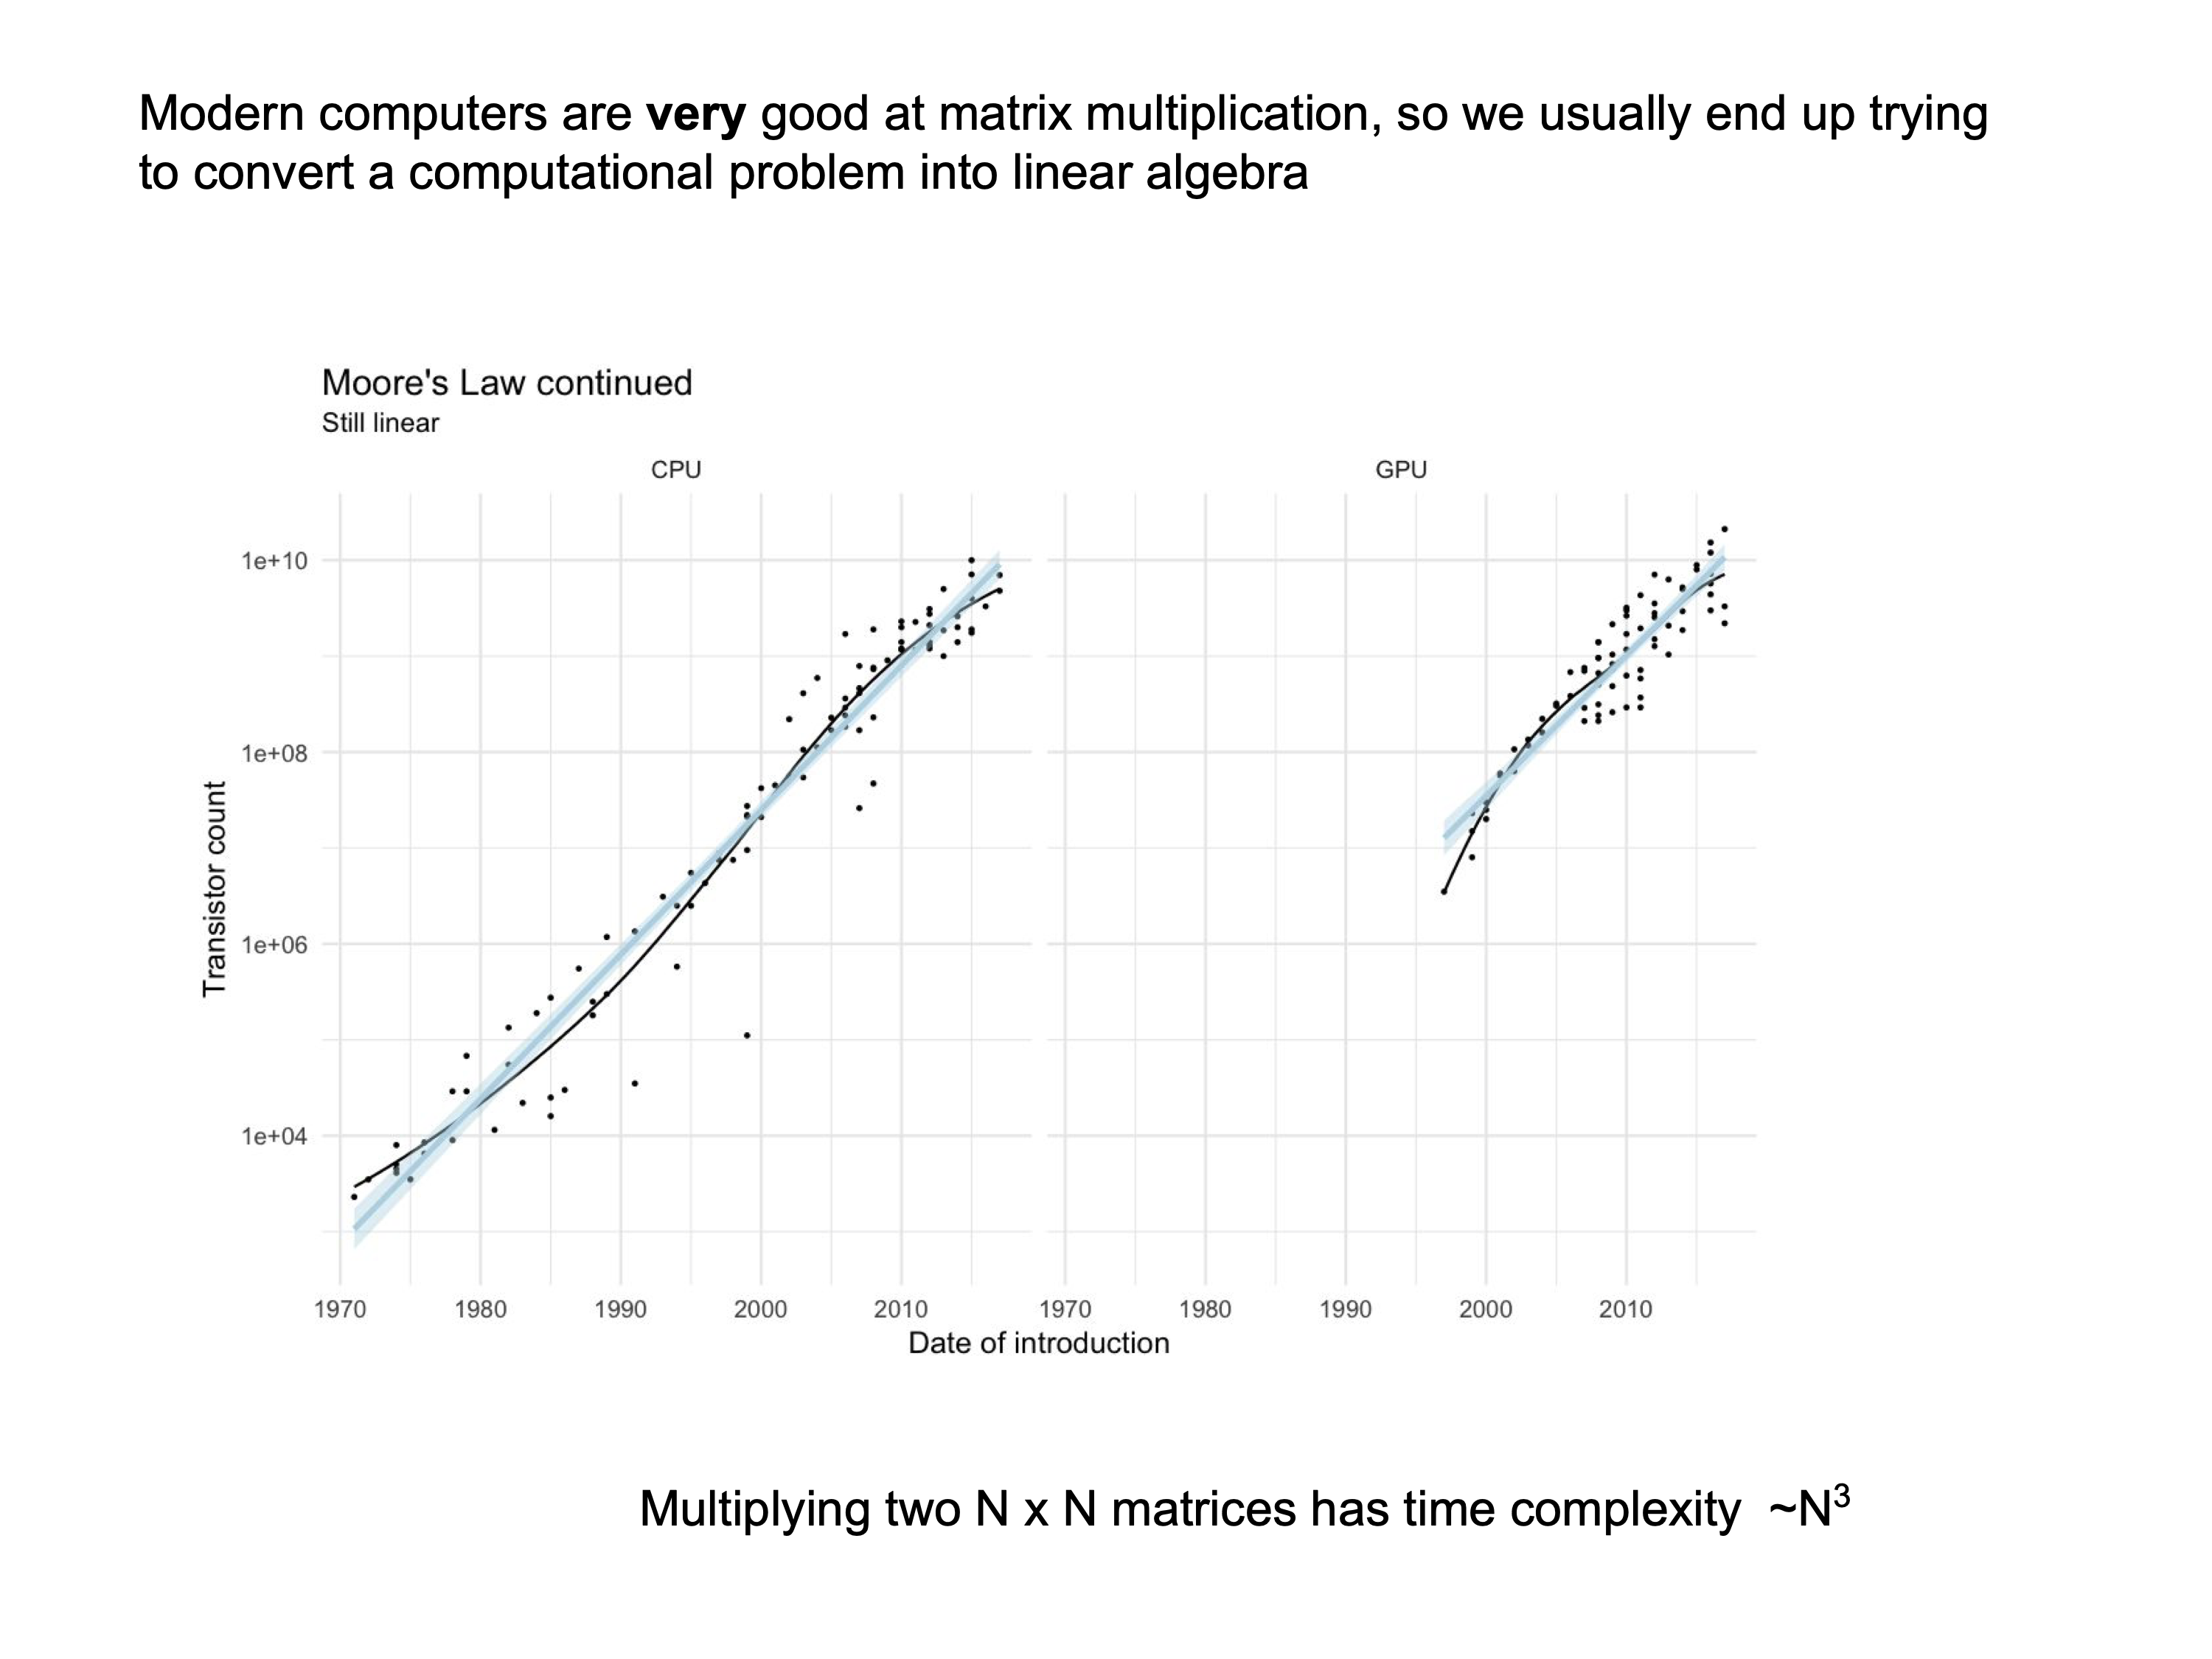

In [3]:
Image("../resources/gpu_scaling.png", width=800)

# Linear problems

Local constitutive laws --> Linear matrix equations
+ Flow networks, resistivity networks
+ Hookean solids, linear perturbations off stable configurations (eg protein folding)
+ $N$ columns denotes the number of unknown variables
+ $M$ rows denotes the number of equations relating the unknowns
+ $M < N$ is underdetermined, $M > N$ is overdetermined. However, this is only true if our matrix has full rank (however, if some variables are functions of others, or some equations are repeated, we can usually eliminate equations or variables to make the problem square)

Write a problem as a linear matrix equation
$$
A \mathbf{x} = \mathbf{b}
$$

Solve for $\mathbf{x}$ using numerical tools to invert $A$

$$
\mathbf{x} = A^{-1} \mathbf{b}
$$

Some issues with finding $A^{-1}$: 
+ A is too large to store in memory
+ A is non-square (over- or under-determined)
+ A is singular or very close to singular (two constraint equations are almost, but not quite the same)

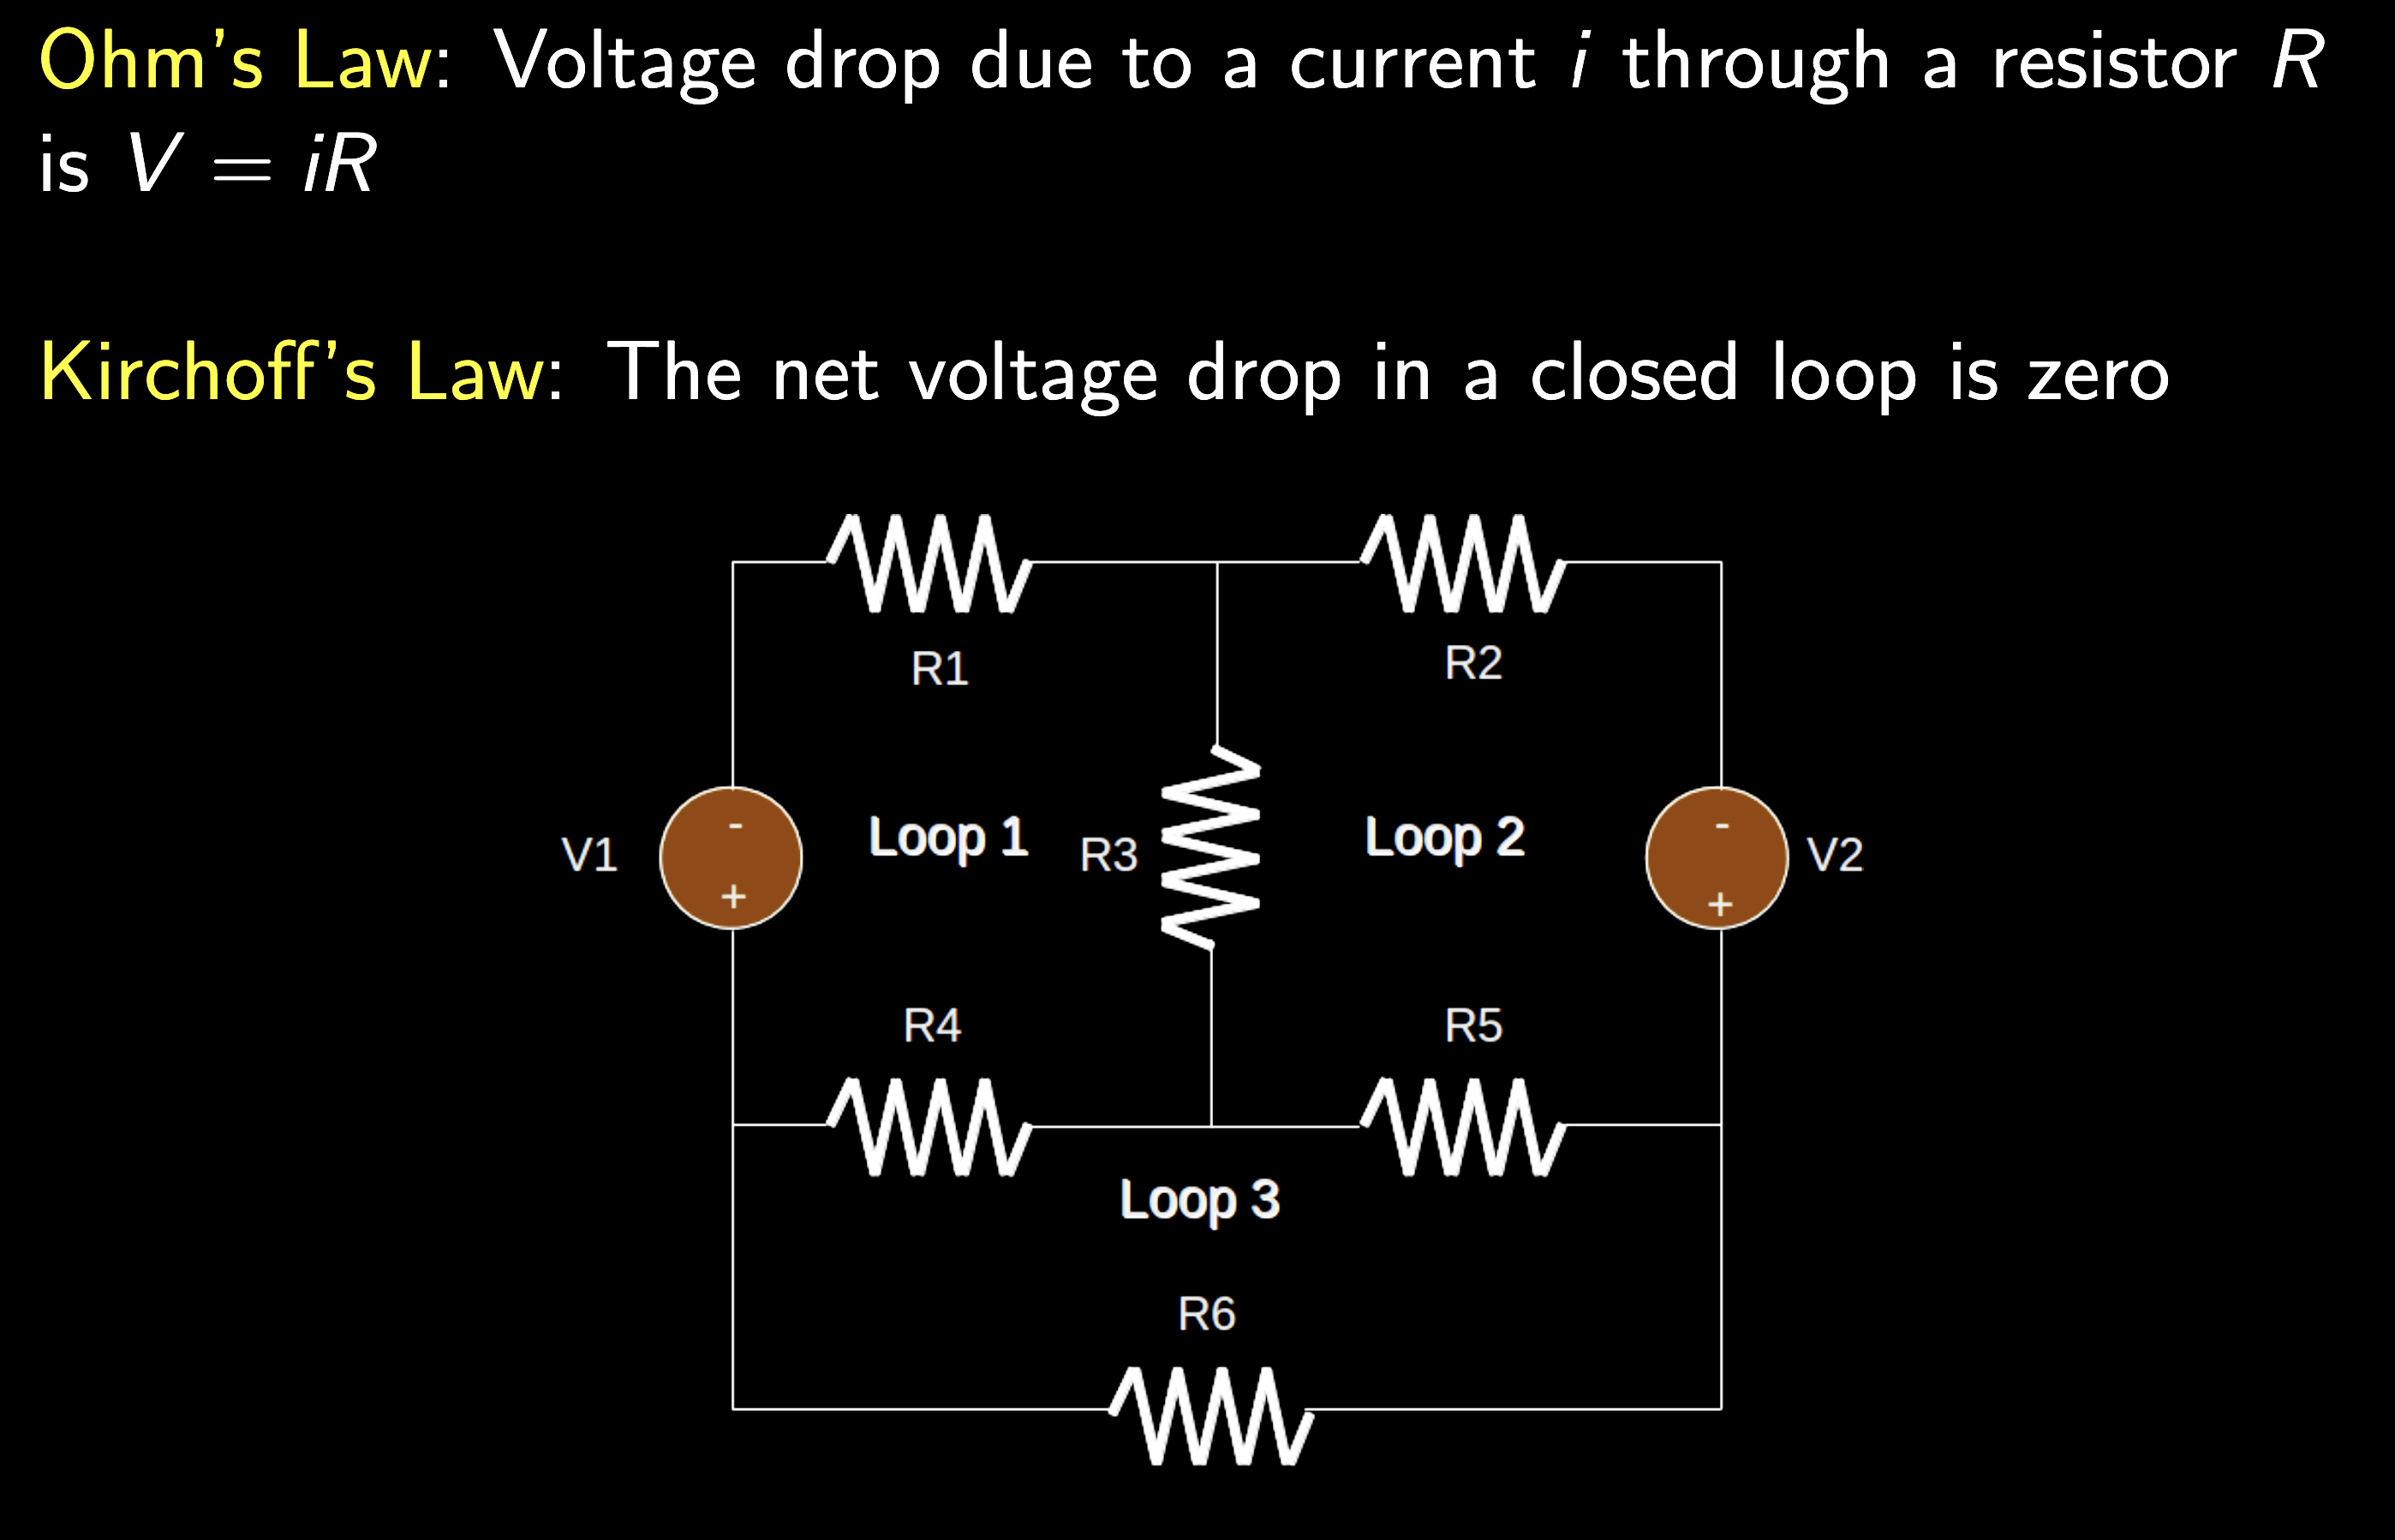

In [139]:
Image("../resources/resistor0.png", width=800)
# Source: Chris Rycroft's AM205 lecture notes

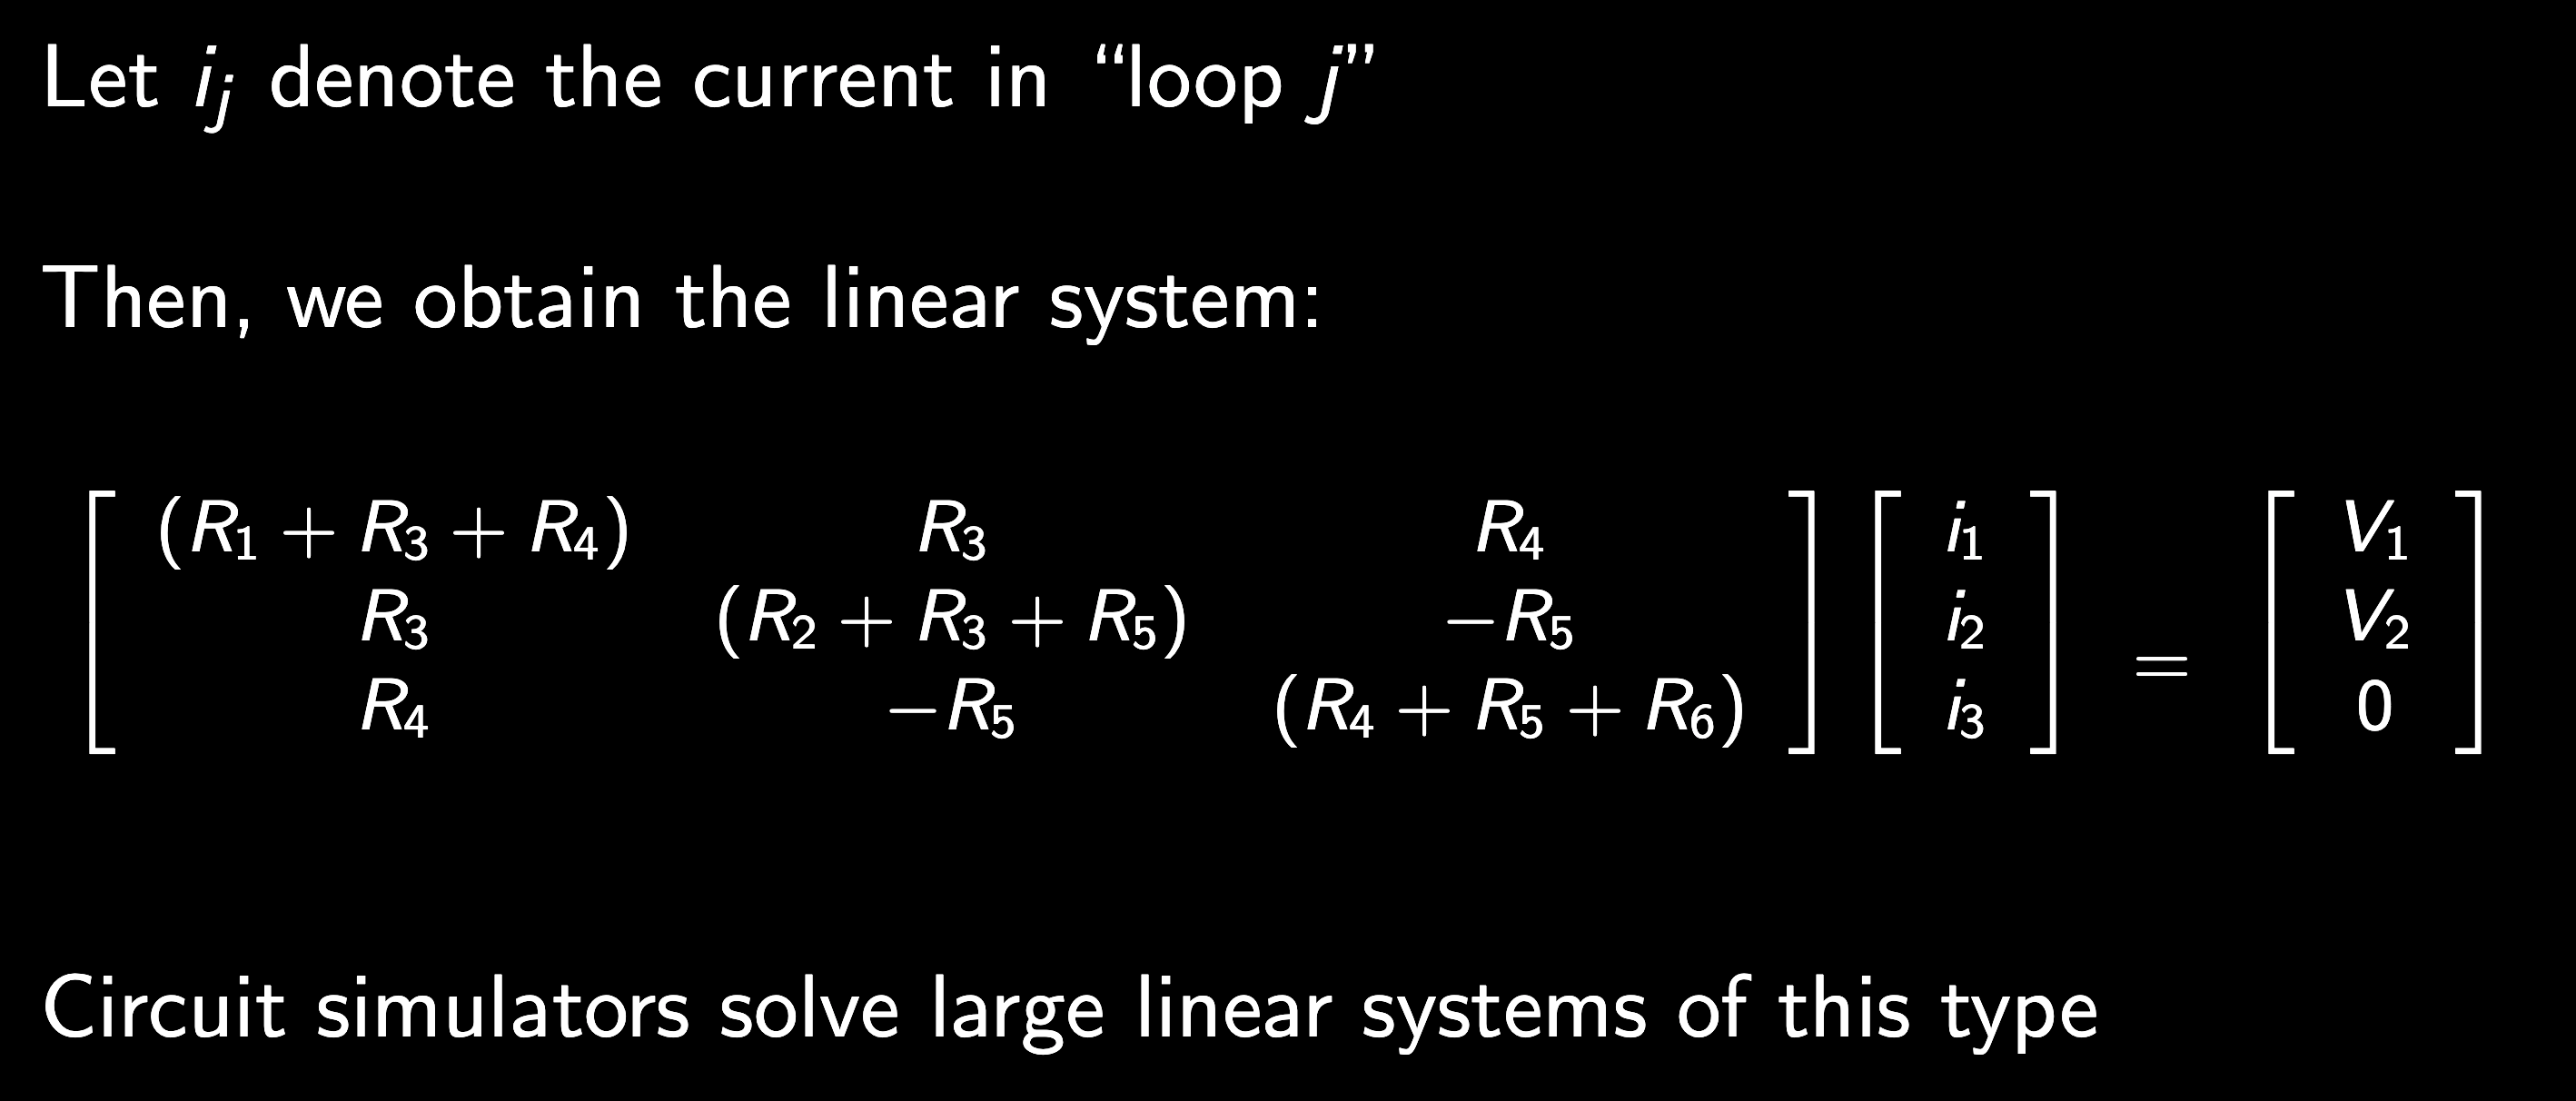

In [140]:
Image("../resources/resistor1.png", width=800)
# Source: Chris Rycroft's AM205 lecture notes

In [138]:
# Some observed "data"
r1, r2, r3, r4, r5, r6 = np.random.random(6)
v1, v2 = np.random.random(2)


coefficient_matrix = np.array([
    [r1 + r3 + r4, r3, r4], 
    [r3, r2 + r3 + r5,  -r5],
    [r4, -r5, r4 + r5 + r6]
])
voltage_vector = np.array([v1, v2, 0])

# Solve the system of equations
# currents = np.linalg.solve(coefficient_matrix, voltage_vector)
currents = np.linalg.inv(coefficient_matrix) @ voltage_vector
print("Observed currents:", currents)

Observed currents: [0.03584899 0.58663333 0.19049614]


## Matrices are collections of vectors

$$
\vec{A} \equiv \pmatrix{\vec{a}_1 & \vec{a}_2 & \cdots & \vec{a}_n}
$$


$$
\vec{A} \cdot \vec{x} = \pmatrix{\vec{a}_1 & \vec{a}_2 & \cdots & \vec{a}_n} \pmatrix{x_1 \\ \vdots \\ x_n}
   = \sum_{k=1}^n x_k \vec{a}_k,
$$

+ Rank: dimension spanned by column space AND rowspace
+ + Implies that if $A \in \mathbb{R}^{M \times N}$, then $\text{rank}(A) \leq \text{min}(M, N)$
+ Span: set of points "reachable" by an operator; for linear operators the column psace
+ Nullspace: matrices with deficient rank have input spaces that map to zero (think of projection operators)
+ Rank-nullity theorem: $dim(Domain) = dim(Image) + dim(NullSpace)$. 
+ Linear independence among columns implies trivial nullspace, and that input domain dimension matches output image dimensionality/span

## Thinking of matrices as dynamical systems

If $A$ is a square matrix, then it can be helpful to think of it as a dynamical system. If not-square, we can always pad zeros.

$\mathbf{x}_{t + 1} = A \mathbf{x}_{t}$

can be written as

$x^i_{t + 1} = \sum_i \mathbf{a}^{(r)} x^i_t$

where $\mathbf{a}^{(r)}$ is a row vector that corresponds to interactions with the other variables that affect the dynamics of $x^i$.

## The columnspace dynamics view gives intuition to some properties

+ You can't undo a projection: If $A \in \mathbb{R}^{M \times N}$, $B \in \mathbb{R}^{N \times K}$, then $\operatorname {rank} (AB)\leq \min(\operatorname {rank} (A),\operatorname {rank} (B)).$
+ For a dynamical system, this means that if you have a system that is evolving in a lower dimensional space, you can't recover the original state from the lower dimensional state.


## Considering the time complexity of matrix inversion

Given $A \in \mathbb{R}^{M \times N}$ and $\mathbf{b} \in \mathbb{R}^{N}$, we wish to solve $A \mathbf{x} = \mathbf{b}$

+ Best case scenario: $A$ is a diagonal matrix

In [13]:
import numpy as np
diag_vals = np.random.randn(5)
ident = np.identity(5)
a = ident * diag_vals
ainv = ident * (1 / diag_vals)

print(a @ ainv)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


We can see that the time complexity of solving this problem is $O(N)$, because just have to touch each diagonal element once, to invert it.

What about an upper-diagonal matrix? 

+ Heuristic: think of an $N \times N$ matrix as a system of $N$ algebraic equations for $N$ unknowns
+ Solve the easy equation, and work your way up 
+ $\sim\mathcal{O}(N^2)$

# What about inverstion of a full $N \times N$ matrix?


#### Naive inversion: schoolyard algebra (Gauss-Jordan)

$$
A = {\displaystyle {\begin{bmatrix}1&3&1\\1&1&-1\\3&11&6\end{bmatrix}}}, \text{\quad} \mathbf{b} = {\begin{bmatrix}9\\1\\35\end{bmatrix}}
$$
Can reduce by multiply by constants or adding two rows. For example, we subtract row 1 from row 2 in the first step
$$
{\displaystyle 
{\begin{bmatrix}1&3&1&9\\1&1&-1&1\\3&11&6&35\end{bmatrix}}\to
{\begin{bmatrix}1&3&1&9\\0&-2&-2&-8\\3&11&6&35\end{bmatrix}}\to 
{\begin{bmatrix}1&3&1&9\\0&-2&-2&-8\\0&2&3&8\end{bmatrix}}\to 
{\begin{bmatrix}1&3&1&9\\0&-2&-2&-8\\0&0&1&0\end{bmatrix}} 
}
$$

We can write the Gauss-Jordan algorithm as a matrix multiplication
$$
\begin{bmatrix}1&3&1\\1&1&-1\\3&11&6\end{bmatrix} \begin{bmatrix}1&0&0\\-1&1&0\\0&-1&1\end{bmatrix} = \begin{bmatrix}1&0&0\\0&1&0\\0&0&1\end{bmatrix}
$$

Based on this, can we guess the time complexity of Gauss-Jordan elimination?

## Sensitivity of matrix inversion: The condition number

+ Tells us how difficult a matrix will be to invert
+ A measure of how sensitive a matrix is to small perturbations
+ The condition number of a matrix is the ratio of the largest singular value to the smallest singular value
+ Matrix norm: $|| A ||_p = (\sum_{ij} |a_{ij}|^p)^{1/p}$. The familiar Frobenius norm is $p=2$ in this equation
+ Condition number: $c \equiv || A ||_p || A^{-1} ||_p$


In [170]:
def matrix_norm(A, p=2):
    """Compute the p-norm of a matrix A."""
    return np.sum(np.abs(A)**p)**(1/p)

def condition_number(A, p=2):
    """Compute the condition number of a matrix A"""
    return matrix_norm(A, p) * matrix_norm(np.linalg.inv(A), p)


Text(0, 0.5, 'Condition number')

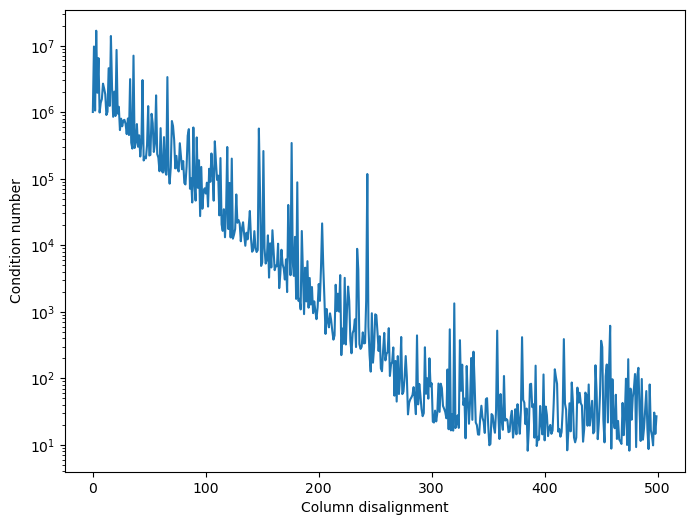

In [172]:
a1 = np.random.random(4)

noise_levels = np.logspace(-5, 3, 500)
all_condition_numbers = []
for noise_level in noise_levels:
    a = np.vstack(
        [
            a1 + np.random.random(a1.shape) * noise_level, 
            a1 + np.random.random(a1.shape) * noise_level, 
            a1 + np.random.random(a1.shape) * noise_level, 
            a1 + np.random.random(a1.shape) * noise_level
        ]
    )
    a /= np.linalg.norm(a)
    all_condition_numbers.append(condition_number(a))

plt.figure(figsize=(8, 6))
plt.semilogy(all_condition_numbers)
plt.xlabel("Column disalignment")
plt.ylabel("Condition number")

In [181]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

## Find fixed axis bounds
vmax = np.max(np.array(eq.history), axis=(0, 1))
vmin = np.min(np.array(eq.history), axis=(0, 1))

eps = np.logspace(-5, 0, 100)
def plotter(i):
    # plt.close()
    a_ill = np.array([
        [1, 1], 
        [0.5, 0.5 + eps[i]], 
    ])
    plt.figure()
    plt.arrow(0, 0, *a_ill[0], head_width=0.05, head_length=0.1, color='black')
    plt.arrow(0, 0, *a_ill[1], head_width=0.05, head_length=0.1, color='b')
    plt.xlim(0, 2)
    plt.ylim(0, 2)
    # annotate condition number on plot
    plt.annotate(
        f"Condition number: {condition_number(a_ill):.2f}",
        xy=(0.5, 1.5),
        xytext=(0.5, 1.5),
        fontsize=16
    )
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(eps) - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=99), Output()), _d…

<function __main__.plotter(i)>

## Practical implications of ill-conditioned matrices

In [248]:


a_well = np.random.random((500, 500))
print("Condition number of well-conditioned matrix: ", condition_number(a_well))

# Make an ill-conditioned matrix by duplicating columns and adding a little noise
a_ill = np.copy(a_well)
a_ill[2:160] = a_ill[10] + 1e-14 * np.random.random(a_ill[2:160].shape)
print("Condition number of ill-conditioned matrix: ", condition_number(a_ill))

# Calculate the solution to a linear system using the solve function
y_target = np.random.random(500)
%timeit np.linalg.solve(a_well, y_target)
%timeit np.linalg.solve(a_ill, y_target)


Condition number of well-conditioned matrix:  2781204.261048967
Condition number of ill-conditioned matrix:  1.5639845020612393e+18
1.12 ms ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.36 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### We can always think of matrices in terms of dynamical systems

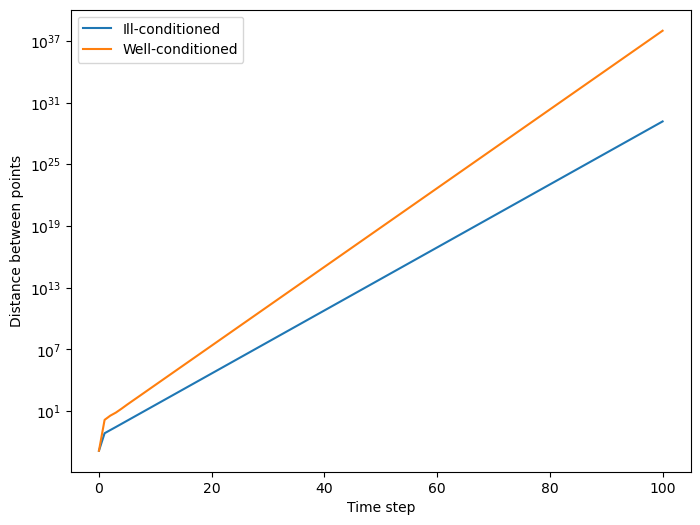

In [184]:
initial_condition = np.array([1, 1])
initial_condition_perturbed = initial_condition + 1e-3

# repeatedly apply the matrix to the initial condition and another one super close to it
all_points = [np.array([initial_condition, initial_condition_perturbed])]
for i in range(100):
    all_points.append(a_ill @ all_points[-1].T)

plt.figure(figsize=(8, 6))

# Calculate separation between the two points vs time
pairwise_dispersion = np.linalg.norm(np.diff(np.array(all_points), axis=1), axis=(1, 2))
plt.semilogy(pairwise_dispersion)

# repeatedly apply the matrix to the initial condition and another one super close to it
all_points = [np.array([initial_condition, initial_condition_perturbed])]
for i in range(100):
    all_points.append(a_good @ all_points[-1].T)

# Calculate separation between the two points vs time
pairwise_dispersion = np.linalg.norm(np.diff(np.array(all_points), axis=1), axis=(1, 2))


plt.semilogy(pairwise_dispersion)
plt.xlabel("Time step")
plt.ylabel("Distance between points")
plt.legend(["Ill-conditioned", "Well-conditioned"])

## The curse of dimensionality

Text(0, 0.5, 'Condition number')

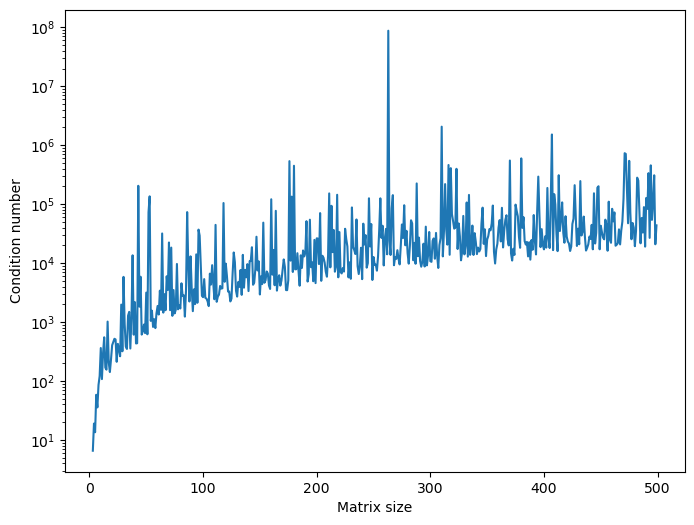

In [185]:
a1 = np.random.random(4)

all_condition_numbers = []
nvals = np.arange(3, 500)
for n in nvals:
    a = np.random.random((n, n))
    # a /= n**2 ## Sanity check that we aren't getting naive scaling
    all_condition_numbers.append(condition_number(a))

plt.figure(figsize=(8, 6))
plt.semilogy(nvals, all_condition_numbers)
plt.xlabel("Matrix size")
plt.ylabel("Condition number")

### Concentration of measure

+ Random high-dimensional vectors tend to be nearly orthogonal

+ The code below calculates random Gaussian vectors with zero mean and unit variance in $N$ dimensions, and then calculates the angle between them


Estimate of asymptotic value: 1.58 +/- 0.05


Text(0, 0.5, 'Angle between random vectors')

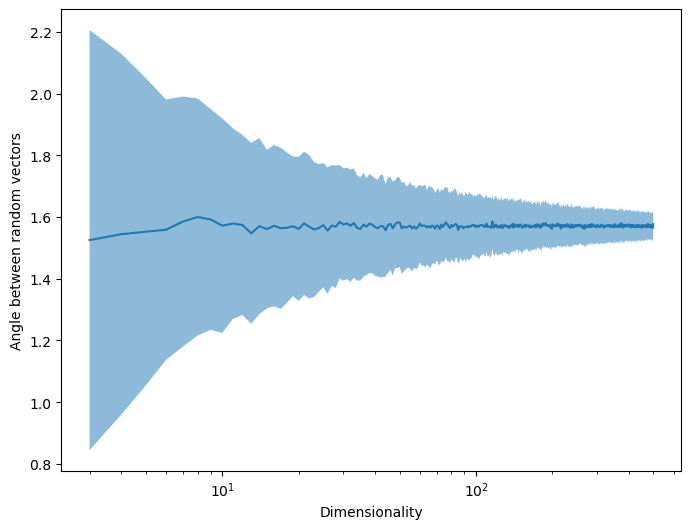

In [221]:
nvals = np.arange(3, 500)

all_angs = []
all_errs = []
for n in range(3, 500):

    # average across 100 replicates
    all_replicates = []
    for _ in range(400):
        a1 = np.random.randn(n)
        a2 = np.random.randn(n)
        ang = np.arccos(np.dot(a1, a2) / (np.linalg.norm(a1) * np.linalg.norm(a2)))
        all_replicates.append(np.abs(ang)) # abs because of negative angles
    all_angs.append(np.mean(all_replicates))
    all_errs.append(np.std(all_replicates))

print(f"Estimate of asymptotic value: {all_angs[-1]:.2f} +/- {all_errs[-1]:.2f}")

plt.figure(figsize=(8, 6))
plt.semilogx(nvals, all_angs)
plt.fill_between(nvals, np.array(all_angs) - np.array(all_errs), np.array(all_angs) + np.array(all_errs), alpha=0.5)
plt.xlabel("Dimensionality")
plt.ylabel("Angle between random vectors")





### The birthday paradox: A loose argument why large, random square matrices tend to be ill-conditioned

A matrix will be ill-conditioned in *any* pair of columns is close to collinear. Imagine a universe where every randomly-sampled vector is a unit vector with exactly one nonzero element. What is the probability that a matrix comprising a set of $N$ length-$N$ unit vectors are mutually orthogonal?

Given just two vectors, the probability of mutual orthogonality is
$$
P_{ortho} = \bigg(1\bigg) \bigg(\dfrac{N -1}{N}\bigg)
$$

Given $N$ vectors, the probability of mutual orthogonality is
$$
P_{ortho} =\dfrac{N!}{N^N}
$$

Stirling's approximation: at large $N$, $N! \sim {\sqrt {2\pi N}}\left({\frac {N}{e}}\right)^{N}$
$$
P_{ortho} \sim \sqrt{2\pi N}e^{-N}
$$

The exponential term dominates at large $N$, and so the odds of getting lucky and having an invertible matrix vanish exponentially with $N$. In this case, the condition number diverges towards infinity.

For random continuous matrices, large matrices have a vanishing probability of being truly singular (you never draw the same multivariate sample twice), but their condition number grows quickly making them "softly" singular


Text(0, 0.5, 'Probability')

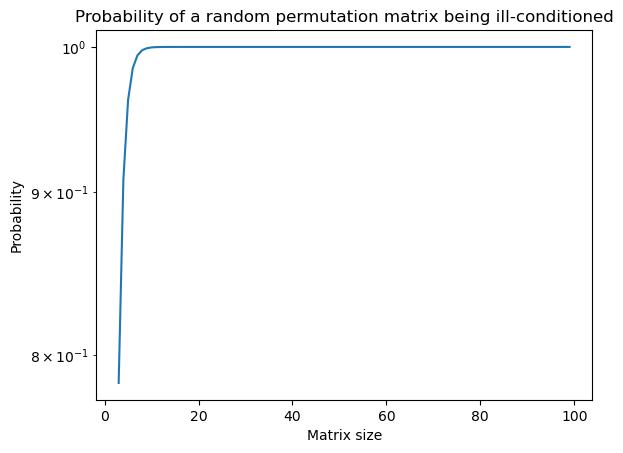

In [414]:

nvals = np.arange(3, 100)
plt.semilogy(nvals, 1 - np.sqrt(2 * np.pi * nvals) * np.exp(-nvals))
plt.title("Probability of a random permutation matrix being ill-conditioned")
plt.xlabel("Matrix size")
plt.ylabel("Probability")

### The Johnson–Lindenstrauss lemma
+ A small set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved

+ We can use random projections to reduce the dimensionality of a matrix, and then solve the problem in the lower-dimensional space

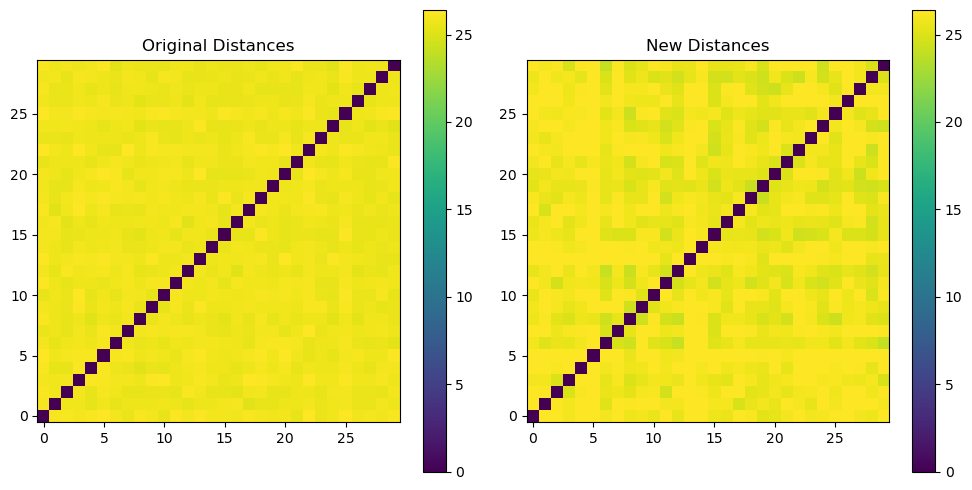

True
True


In [237]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a set of high-dimensional vectors (e.g., 1000-dimensional)
num_points = 30
dim = 4000
X = np.random.rand(num_points, dim)

# Define the reduced dimension and epsilon
new_dim = 500  # You can vary this based on the lemma's guidelines for your chosen epsilon
epsilon = 0.5

# Create a random projection matrix
projection_matrix = np.random.randn(new_dim, dim) / np.sqrt(new_dim)

# Project the high-dimensional vectors into the lower-dimensional space
X_new = X.dot(projection_matrix.T)

# Compute pairwise distances in the original and reduced spaces
dist_original = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=-1)
dist_new = np.linalg.norm(X_new[:, None, :] - X_new[None, :, :], axis=-1)

# Step 6: Plot the original and new distances
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(dist_original, origin='lower', vmin=np.min(dist_original), vmax=np.max(dist_original))
plt.title('Original Distances')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(dist_new,  origin='lower', vmin=np.min(dist_original), vmax=np.max(dist_original))
plt.title('New Distances')
plt.colorbar()
plt.tight_layout()
plt.show()


# Check that the distances are approximately preserved to within epsilon
print(np.all((1 - epsilon) * dist_original <= dist_new))
print(np.all(dist_new <= (1 + epsilon) * dist_original))

## Condition number and the irreversibility of chaos

The Lorenz equations are a set of three coupled nonlinear ordinary differential equations that exhibit a transition to chaos,

$$
\begin{aligned}
\dot{x} &= \sigma (y-x) \\
\dot{y} &= x (\rho - z) - y \\
\dot{z} &= x y - \beta z
\end{aligned}
$$

where $\sigma$, $\rho$, and $\beta$ are parameters. These equations exhibit chaotic dynamics when $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$. The degree of chaos can be varied by changing the parameter $\rho$.

We can linearize these equations by computing the Jacobian matrix, which is the matrix of all first-order partial derivatives of the system. The Jacobian matrix is


$$
\mathbb{J}(\mathbf{x}) =  \dfrac{d \mathbf{\dot{x}}}{d \mathbf{x}} = \begin{bmatrix}
-\sigma & \sigma & 0 \\
\rho - z & -1 & -x \\
y & x & -\beta
\end{bmatrix}
$$

Notice how, unlike a globally linear dynamical system, the Jacobian matrix $\mathbb{J}(\mathbf{x})$ is a function of the state vector $\mathbf{x}$. This means that the linearization of the system is only valid for a small region of state space around the point $\mathbf{x}$.

We can use the linearization of this system to create a simple finite-differences integration scheme. The linearized system is

$$
\mathbf{x}_{t+1} = \mathbf{x}_t + \Delta t\, \mathbb{J}(\mathbf{x}_t) \mathbf{x}_t 
$$

or, equivalently,

$$
\mathbf{x}_{t+1} = \left( \mathbb{I} + \Delta t\, \mathbb{J}(\mathbf{x}_t) \right) \mathbf{x}_t
$$

where $\mathbb{I}$ is the identity matrix.

We will see more sophisticated integration schemes later in the course, but this particular update rule in this case is a linear scheme with a forward update rule.

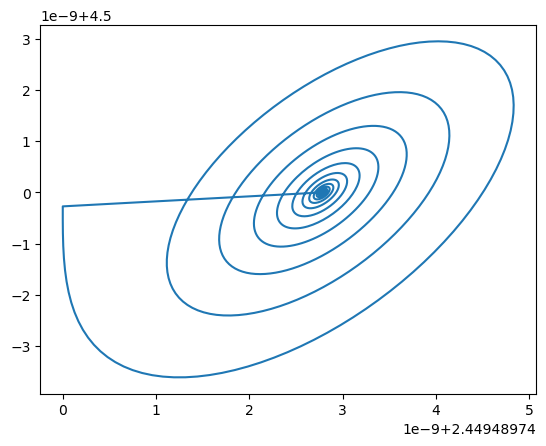

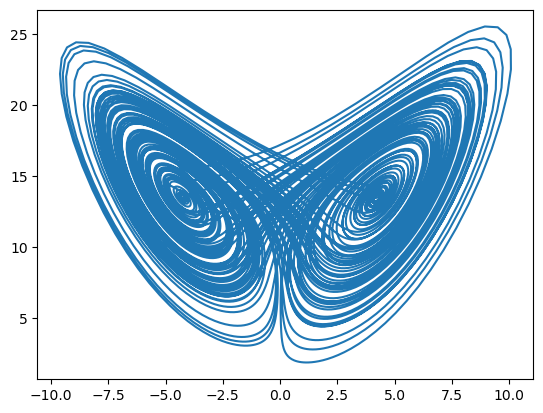

In [403]:
class Lorenz:
    """
    The Lorenz equations describe a chaotic system of differential equations
    """
    def __init__(self, sigma=10, rho=28, beta=8/3):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def rhs(self, x):
        x, y, z = x
        return np.array([
            self.sigma * (y - x), 
            x * (self.rho - z) - y, 
            x * y - self.beta * z
        ])
    
    def jacobian(self, x):
        x, y, z = x
        return np.array([
            [-self.sigma, self.sigma, 0], 
            [self.rho - z, -1, -x], 
            [y, x, -self.beta]
        ])
    
    def integrate(self, x0, t0, t1, dt):
        """
        Integrate using the jacobian and forward euler
        """
        x = x0
        all_x = [x]
        all_t = [t0]
        while t0 < t1:
            jac = self.jacobian(x)
            x += jac @ x * dt
            t0 += dt
            all_x.append(x.copy())
            all_t.append(t0)
        return np.array(all_x), np.array(all_t)
    


# A parameter value that doesn't exhibit chaos
eq = Lorenz(rho=10)
x0 = np.array([2.44948974, 2.44948974, 4.5]) 
x_nonchaotic, all_t = eq.integrate(x0, 0., 100., 0.01)
plt.figure()
plt.plot(x_nonchaotic[:, 0], x_nonchaotic[:, 2])


eq = Lorenz()
x0 = np.array([-5.0,  -5.0, 14.4]) # pick initial condition on the attractor
x_chaotic, all_t = eq.integrate(x0, 0., 100., 0.01)
plt.figure()
plt.plot(x_chaotic[:, 0], x_chaotic[:, 2])




## The condition number

Now we can evaluate the condition number of the Jacobian matrix $\mathbb{J}(\mathbf{x})$ at a particular point $\mathbf{x}$. The condition number is defined as

$$
\kappa(\mathbf{x}) = || \mathbb{J}(\mathbf{x}) || \, || \mathbb{J}^{-1}(\mathbf{x}) ||
$$

Because the system is not Hamiltonian, we cannot simplify this expression using the eigenvalues of the Jacobian matrix.



Text(0, 0.5, 'Condition number')

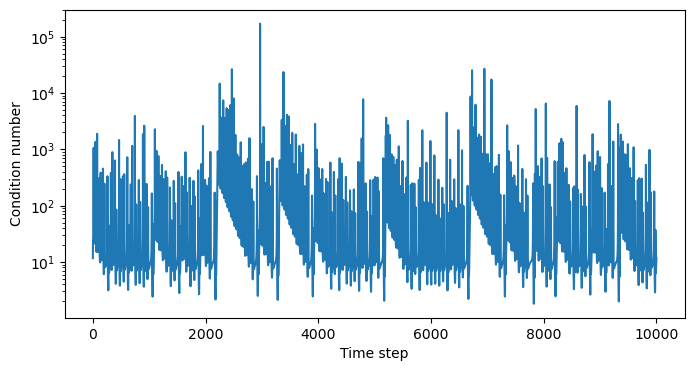

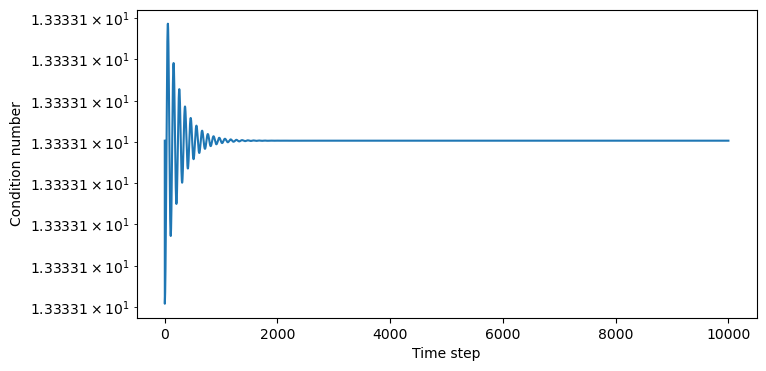

In [413]:
jac_chaotic = np.array([eq.jacobian(x) for x in x_chaotic])
plt.figure(figsize=(8, 4))
plt.semilogy(
    [np.linalg.cond(item) for item in jac_chaotic]
)
plt.xlabel("Time step")
plt.ylabel("Condition number")

jac_nonchaotic = np.array([eq.jacobian(x) for x in x_nonchaotic])
plt.figure(figsize=(8, 4))
plt.semilogy(
    [np.linalg.cond(item) for item in jac_nonchaotic[:]]
)
plt.xlabel("Time step")
plt.ylabel("Condition number")

## Questions

+ In the chaotic case, why is the condition number still a positive, albeit smaller, number? What physical circumstances might decrease this number?

## Preconditioning

+ Use domain or problem knowledge to transform a matrix into a better-conditioned problem
+ Depends strongly on the problem type, and any known structure in the matrix we seek to invert
+ In ML, using domain knowledge to restrict model space is known as an "inductive bias"

For example, for a linear problem we might seek the "left" preconditioning matrix $Q$
$$
A \mathbf{x} = \mathbf{y}           \\
Q A \mathbf{x} = Q \mathbf{y}       \\
\mathbf{x} = (Q A)^{-1} Q \mathbf{y}  \\
$$
Hopefully, $(Q A)^{-1}$ is easier to compute than $A^{-1}$



Another option is to perform the preconditioning in a different order
$$
A \mathbf{x} = \mathbf{y}           \\
A P^{-1} P \mathbf{x} = \mathbf{y}  \\
$$
where we first solve for a latent variable $\mathbf{z}$
$$
\mathbf{z} = (A P^{{-1}})^{-1} \mathbf{y}
$$
And then separately solve for the unknown $\mathbf{x}$
$$
\mathbf{x} = P^{-1} \mathbf{z}
$$

There are many heuristics for choosing $Q$ or $P$ depending on the problem. [Here](https://web.ma.utexas.edu/CNA/NSPCG/manuals/usernsp/node7.html) are some common ones. The concept of preconditioning will motivate change of basis and spectral methods for solving partial differential equations

In [418]:
## Make a high condition number matrix
a1 = np.random.random(4)
a = np.vstack([a1, a1, a1, a1]) 
a += np.random.random(a.shape) * 1e-5
print("Full condition number:", condition_number(a), "\n")


## Use split conditioning

# This is called Jacobi conditioning
p = np.identity(a.shape[0]) * np.diag(a)
pinv = np.identity(a.shape[0]) * 1 / np.diag(a) # Inverse of diagonal matrix easy to calculate

print("Partial condition number 1: ", condition_number(a @ pinv))
print("Partial condition number 2: ", condition_number(p))


Full condition number: 1447098.474250782 

Partial condition number 1:  1292220.0701494408
Partial condition number 2:  8.819594121508297


# Appendix / Future

As a physics example, we consider a large $2D$ network of $N$ point masses of equal length $m$ connected by springs of random resistivity and resting length $\mathbf{r}_0$. If $\mathbf{r}(t) \in \mathbb{R}^{2N}$ is the vector of positions of the point masses, then the equations of motion with damping are given by

$$
m \ddot{\mathbf{x}} = -\gamma \dot{\mathbf{x}} - K \mathbf{x}
$$

where we define the displacement vector $\mathbf{x} = \mathbf{r} - \mathbf{r}_0$, where $K \in \mathbb{R}^{2N \times 2N}$ is the matrix of resistivities. We assume that we are in the overdamped regime $\gamma / m \gg 1$, so that the inertial term is negligible,

$$
\dot{\mathbf{r}} = -\frac{1}{\gamma} K \mathbf{x}
$$

In [ ]:
# use networkx to create a random spring network

import networkx as nx

# Create a random spring network
G = nx.random_geometric_graph(100, 0.2, seed=1)

# random connected small graph
G = nx.random_tree(7, seed=1)

# plot the network
plt.figure(figsize=(5, 5))
nx.draw(G, node_size=10, node_color='r', width=0.5)


# # Get the adjacency matrix
A = nx.adjacency_matrix(G).todense()

# simulate forces subject to the spring network

from scipy.spatial.distance import cdist

class RandomSpringNetwork:
    """Given a networkx graph, simulate the dynamics of a random spring network"""

    def __init__(self, G, dt=0.01, random_state=None, store_history=False):
        self.dt = dt
        self.random_state = random_state
        self.store_history = store_history
        self.n = len(G.nodes)
        self.A = nx.adjacency_matrix(G).todense()
        self.pos = np.random.random((self.n, 2))
        self.vel = np.zeros((self.n, 2))
        self.acc = np.zeros((self.n, 2))
        self.forces = np.zeros((self.n, 2))
        self.step = 0
        
        # resting length
        self.rest_length = 0.3 * np.random.random(self.n)

        if self.store_history:
            self.history = [self.pos.copy()]

    def simulate(self, steps=100):
        """Simulate the dynamics of the spring network for a given number of steps"""
        for _ in range(steps):
            self.step += 1
            self.compute_forces()
            self.update()
            self.update_positions()

    def compute_forces(self):
        """Compute the forces acting on each node"""
        self.forces = np.zeros((self.n, 2))
        for i in range(self.n):
            for j in range(self.n):
                if i != j and self.A[i, j]:
                    ## compute the forces between node i and node j accounting
                    ## for the resting length of the spring
                    self.forces[i] += 0.1 * (self.pos[j] - self.pos[i]) * (np.linalg.norm(self.pos[j] - self.pos[i]) - self.rest_length[i])

    def update(self):
        """Update the velocity and acceleration of each node"""
        self.acc = self.forces
        self.vel += self.acc * self.dt

        # overdamped limit
        self.vel = self.forces

    def update_positions(self):
        """Update the position of each node"""
        self.pos += self.vel * self.dt
        if self.store_history:
            self.history.append(self.pos.copy())

eq = RandomSpringNetwork(G, dt=0.1, random_state=0, store_history=True)
eq.simulate(steps=5000)

# plot the network
plt.figure(figsize=(5, 5))
nx.draw(G, pos=eq.pos, node_size=10, node_color='r', width=0.5)


In [ ]:
from scipy.spatial.distance import cdist


def find_fixed_point(K, R0, X0):
    N, _ = X0.shape
    unit_vectors = X0[:, None, :] - X0[None, :, :]  # N x N x 2 array of vector differences
    distances = np.linalg.norm(unit_vectors, axis=2)  # N x N distance matrix
    distances += np.finfo(float).eps
    direction_matrices = np.divide(unit_vectors, distances[:, :, None], where=distances[:, :, None]!=0)  # normalize, safely handling divide by zero

    # Calculate the force matrices with the given resting length
    F_matrices = K[:, :, None] * (distances[:, :, None] - R0[:, None, None]) * direction_matrices

    # Setting up the matrix equation AX = B to solve for X
    A = np.einsum('ijk,ijl->ikl', direction_matrices, K[:, :, None] * direction_matrices)  # Constructing the A matrix with dot products

    # Formulating B matrix
    B = -np.sum(F_matrices, axis=1)  # Summing the forces to get the net force (B vector)

    # Finding the fixed point by solving the matrix equation
    fixed_point_positions = np.linalg.solve(A, B)
    
    return fixed_point_positions


s = find_fixed_point(eq.A, eq.rest_length, eq.history[0])

In [ ]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

## Find fixed axis bounds
vmax = np.max(np.array(eq.history), axis=(0, 1))
vmin = np.min(np.array(eq.history), axis=(0, 1))

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(6, 6))
    # plt.imshow(eq.pos_history[i], vmin=0, vmax=1, cmap="gray")
    nx.draw(G, pos=eq.history[i], node_size=10, node_color='r', width=0.5)
    plt.xlim(vmin[0], vmax[0])
    plt.ylim(vmin[1], vmax[1])
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(eq.history) - 1, 1, layout=Layout(width='800px'))
)